# MNIST Active Learning POC

General idea: Achieve the highest possible accuracy, with the lowest amount of train data using (supervised learning).

We start from a pool of unlabeled data and a test set. Then, we itiretaively query new samples to be annotated, and re-train the model.

In [141]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from scipy import stats

import collections

import forestci as fci

import warnings
warnings.filterwarnings('ignore')

## MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


## Baseline model

In [3]:
# the batch size will be used as the number of new images to annotate
BATCH_SIZE = 128
BASELINE_EPOCHS = 6
VALIDATION_SPLIT = 0.2

baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

baseline_model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=BASELINE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=0,
)

2022-04-27 11:31:24.587793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 11:31:24.587813: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 11:31:24.587824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eoc-001261l): /proc/driver/nvidia/version does not exist
2022-04-27 11:31:24.588028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 11:31:24.760496: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Op

In [4]:
_, baseline_metrics = baseline_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=0,
)

print("SparseCategoricalAccuracy", baseline_metrics)

SparseCategoricalAccuracy 0.9725000262260437


## Randomly Added Images

In [5]:
INIT_SIZE = int(len(x_train) * 0.01)
print("Initial number of annotated images", INIT_SIZE, "out of", len(x_train))

BUDGET = BASELINE_EPOCHS * len(x_train)
print("The budget consists of", BUDGET, "forward passes")

ACTIVE_EPOCHS = 1
print("Every round, the network is trained for", ACTIVE_EPOCHS, "epoch(s)")

Initial number of annotated images 600 out of 60000
The budget consists of 360000 forward passes
Every round, the network is trained for 1 epoch(s)


In [6]:
annotated_ix = list()

annotated_ix = annotated_ix + np.random.choice(range(len(x_train)), 
                                               size=INIT_SIZE, replace=False).tolist()

x_train_annotated = x_train[annotated_ix]    
y_train_annotated = y_train[annotated_ix]

print("Size of initial set of annotated images", len(x_train_annotated))

random_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

random_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

random_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=ACTIVE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=0,
)

random_spent = ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
print(random_spent, "out of", BUDGET, "forward passes done")

Size of initial set of annotated images 600
480.0 out of 360000 forward passes done


In [7]:
_, metrics = random_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=0,
)

print("SparseCategoricalAccuracy", metrics)

random_metrics = [metrics]
random_budget = [random_spent]
random_annotated = [len(x_train_annotated)]

SparseCategoricalAccuracy 0.41179999709129333


In [8]:
while random_spent < BUDGET:
    ix_pool = np.delete(range(len(x_train)), annotated_ix)

    annotated_ix = annotated_ix + np.random.choice(ix_pool, 
                                                   size=BATCH_SIZE, replace=False).tolist()

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    random_model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    random_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    random_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=BATCH_SIZE,
        epochs=ACTIVE_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    _, metrics = random_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    # print("SparseCategoricalAccuracy", metrics, "on", len(x_train_annotated), "annotated images")

    random_metrics.append(metrics)
    
    random_spent = random_spent + ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
    # print(random_spent, "out of", BUDGET, "forward passes done")
    random_budget.append(random_spent)
    random_annotated.append(len(x_train_annotated))

The following plot shows the accuracy on test achieved by the model after *n* forward passess (training). The solid red line shows the accuracy achieved by the model using 100% of the trianing data after trianing for an equivalent time (i.e. the same number of forward passess).

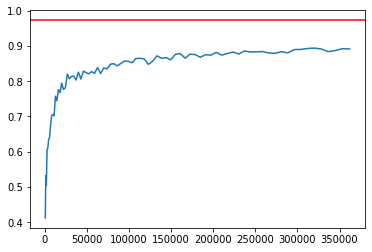

In [9]:
plt.plot(random_budget, random_metrics)
plt.axhline(baseline_metrics, color='r')

The following plot shows the accuracy on test achieved by the model usign *x*% of annotated training data (incrementally). The solid red line shows the accuracy achieved by the model using 100% of the trianing data after trianing for an equivalent time (i.e. the same number of forward passess).

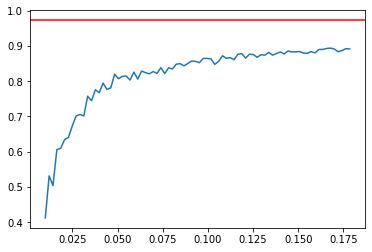

In [10]:
random_annotated_perc = np.array(random_annotated) / len(x_train)
plt.plot(random_annotated_perc, random_metrics)
plt.axhline(baseline_metrics, color='r')

## Clustering

In [11]:
x_train_flat = np.reshape(
    x_train, 
    (len(x_train), x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
)

# TODO: the number of cluster should be adjusted using internal/external validation metrics
N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(x_train_flat)


In [36]:
def norm_ratios(
    labels,
    sum_up_to,
    classes,
    inclusion=True):
    """ Given an array of classes (labels), returns an array of
    elements per class (ratio) that sum up to a given number.
    In other words, the sum of all returned elements is equal to
    'sum_up_to'.
    """
    labels_counts = collections.Counter(labels)    

    # select a repersentative initial set of images to be annotated
    counts = list()
    for i in classes:
        counts.append(labels_counts[i])

    counts = np.array(counts)
    _min = counts.min() if counts.min() > 0 else 1
    _sum = counts.sum() if counts.sum() > 0 else 1
    
    counts = counts / _min
    counts = counts / _sum
    counts = counts * sum_up_to
    counts = counts.astype(int)

    if inclusion:
        # to avoid smalls clusters to be left out, we add at least one element per cluster
        counts[counts == 0] = 1

    while counts.sum() != sum_up_to:
        if counts.sum() > sum_up_to:
            counts[counts.argmax()] = counts[counts.argmax()] - 1
        elif counts.sum() < sum_up_to:
            counts[counts.argmin()] = counts[counts.argmin()] + 1
            
    return counts

In [13]:
# we will use the number of elements per cluster to select the initial batch
counts = norm_ratios(kmeans.labels_, INIT_SIZE, range(N_CLUSTERS))
print("Images by class adjusted to sum up to the initial amount of annotated data",
      counts)

set_ix = list()
for i in range(len(counts)):
    pos = np.where(kmeans.labels_ == i)[0]    
    if len(pos) >= counts[i]:
        set_ix = set_ix + np.random.choice(pos, size=counts[i], replace=False).tolist()
    elif len(pos) > 0:
        set_ix = set_ix + pos
    
annotated_ix = set_ix.copy()

x_train_annotated = x_train[annotated_ix]    
y_train_annotated = y_train[annotated_ix]

print("Size of initial set of annotated images", len(x_train_annotated))

Images by class adjusted to sum up to the initial amount of annotated data [55 89 34 74 59 65 88 46 33 57]
Size of initial set of annotated images 600


In [14]:
active_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

active_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

active_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=ACTIVE_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    verbose=0,
)

active_spent = ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
print(active_spent, "out of", BUDGET, "forward passes done")

480.0 out of 360000 forward passes done


In [15]:
_, metrics = active_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=0,
)

print("SparseCategoricalAccuracy", metrics)

active_metrics = [metrics]
active_budget = [active_spent]
active_annotated = [len(x_train_annotated)]

SparseCategoricalAccuracy 0.3741999864578247


**NOTE:** Should we use the test data to check instead?

In [16]:
while active_spent < BUDGET:
    preds = active_model.predict(x_train_annotated)
    preds_class = np.argmax(preds, axis=1)
    misclassified_relative = np.where((preds_class - y_train_annotated)!=0)
    misclassified_pos = np.take(annotated_ix, misclassified_relative)
    misclassified_cluster_no = np.take(kmeans.labels_, misclassified_pos)

    # compute ratio of misclassified classes
    counts_active = norm_ratios(misclassified_cluster_no.ravel(), BATCH_SIZE, range(N_CLUSTERS))
    # print("Misclasification by class adjusted to sum up to a batch", counts_active)

    # select new images to annotate with the given ratios
    ix_pool = np.delete(range(len(x_train)), annotated_ix)
    weak_labels_ix_pool = np.delete(kmeans.labels_, annotated_ix)

    set_ix = list()
    for i in range(len(counts_active)):
        pos = np.where(weak_labels_ix_pool == i)[0]                    
        if len(pos) >= counts_active[i]:
            set_ix = set_ix + np.random.choice(
                ix_pool[pos], 
                size=counts_active[i], 
                replace=False).tolist()
        elif len(pos) > 0:
            set_ix = set_ix + ix_pool[pos]        

    # print("Adding", len(set_ix), "annotated images")

    annotated_ix = annotated_ix + set_ix

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    # print("Current size of set of annotated images", len(x_train_annotated))
    
    active_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=BATCH_SIZE,
        epochs=ACTIVE_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    _, metrics = active_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    # print("SparseCategoricalAccuracy", metrics)

    active_metrics.append(metrics)
    active_spent = active_spent + ACTIVE_EPOCHS * (1 - VALIDATION_SPLIT) * len(x_train_annotated)
    # print(random_spent, "out of", BUDGET, "forward passes done")
    active_budget.append(active_spent)
    active_annotated.append(len(x_train_annotated))

## Results Compared

First, as a sanity check, we train from *scratch* the same model using the annotated data.

In [17]:
cmp_epochs = int(BUDGET / len(x_train_annotated))

cmp_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

cmp_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

cmp_model.fit(
    x=x_train_annotated,
    y=y_train_annotated,
    batch_size=BATCH_SIZE,
    epochs=cmp_epochs,
    validation_split=VALIDATION_SPLIT,
    verbose=0,
)

_, cmp_metrics = cmp_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=0,
)

print("SparseCategoricalAccuracy", cmp_metrics)

SparseCategoricalAccuracy 0.9538999795913696


In [18]:
annotated_perc = len(x_train_annotated) / len(x_train)
annotated_perc = int(annotated_perc * 100)

print('Baseline (100% data)', baseline_metrics)
print('Baseline (', annotated_perc, '% data)', cmp_metrics)
print('Random (', annotated_perc, '% data)',random_metrics[-1])
print('Active (', annotated_perc, '% data)',active_metrics[-1])

Baseline (100% data) 0.9725000262260437
Baseline ( 17 % data) 0.9538999795913696
Random ( 17 % data) 0.8910999894142151
Active ( 17 % data) 0.9483000040054321


The following plot shows the accuracy on test achieved by the model after *n* forward passess (training) using the active selection approach (*green*), and the random approach (*blue*). The solid red line shows the accuracy achieved by the model using 100% of the trianing data and the *annotated* data (*yellow*) after trianing for an equivalent time (i.e. the same number of forward passess) from scratch.

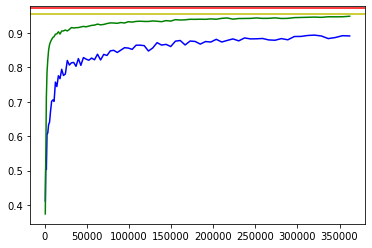

In [19]:
if np.sum(np.array(random_budget) - np.array(active_budget)) != 0:
    print("Error: The random and active budgets do not match")

if np.sum(np.array(random_annotated) - np.array(active_annotated)) != 0:
    print("Error: The random and active annotated counts do not match")

plt.plot(random_budget, random_metrics, color='b')
plt.plot(random_budget, active_metrics, color='g')
plt.axhline(baseline_metrics, color='r')
plt.axhline(cmp_metrics, color='y')

The following plot shows the accuracy on test achieved by the model usign *x*% of annotated training data with the active selection approach (*green*) and random (*blue*). The solid red line shows the accuracy achieved by the model using 100% of the trianing data and the *annotated* data (*yellow*) after trianing for an equivalent time (i.e. the same number of forward passess) from scratch.

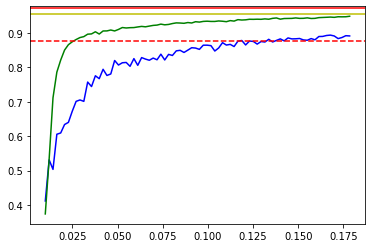

In [23]:
plt.plot(random_annotated_perc, random_metrics, color='b')
plt.plot(random_annotated_perc, active_metrics, color='g')
plt.axhline(baseline_metrics, color='r')
plt.axhline(cmp_metrics, color='y')
plt.axhline(baseline_metrics*0.9, color='r', linestyle='dashed')

In [31]:
p90 = np.min(np.where(np.array(active_metrics) > baseline_metrics*0.9))
active_annotated[p90]

1624

# Achieve P% Accuracy

In [32]:
P = 0.9
target_accuracy = baseline_metrics * P
print('Target accuracy', target_accuracy, '(', P, '%)')

Target accuracy 0.8752500236034394 ( 0.9 %)


In [33]:
def auto_cluster_size(
    x_train_flat,
    max_n_clusters):
    """ Set automatically the optimal number of clusters
    """
    print("Warning: The automatic setting of the number of clusters is not yet implemented")
    return 10

In [139]:
def samp_var_acquisition_fn(
    x_train_annotated,
    y_train_annotated,
    x_test_not_annotated,
    sample_size):
    """
    """
    if sample_size <= 0:
        return np.array([])
    
    if len(x_train_annotated) == 0:
        return np.random.choice(
            range(len(x_test_not_annotated)), 
            size=sample_size, 
            replace=False)
    
    rf = RandomForestClassifier(random_state=0)
    rf.fit(x_train_annotated, y_train_annotated)
    # y_pred = rf.predict(x_test_not_annotated)
    unbiased_samp_var = fci.random_forest_error(rf, x_train_annotated, x_test_not_annotated)    
    #ix_samples = np.argpartition(unbiased_samp_var, 
    #                             (len(unbiased_samp_var) - sample_size))[-sample_size:]
    ix_samples = np.argpartition(unbiased_samp_var, sample_size)[:sample_size]
    
    return ix_samples

In [130]:
pos

array([    9,    14,    27, ..., 49399, 49403, 49414])

In [146]:
def active_cluster(
    x_train,
    y_train,
    p_batch_size,
    p_epochs,
    p_init,
    max_n_clusters,
    target_accuracy,
    custom_acquisition_fn=None):
    """
    """
    x_train_flat = np.reshape(
        x_train, 
        (len(x_train), x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
    )
    
    n_clusters = auto_cluster_size(x_train_flat, max_n_clusters)
    p_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x_train_flat)
    
    # we will use the number of elements per cluster to select the initial batch
    counts = norm_ratios(p_kmeans.labels_, p_init, range(n_clusters))

    set_ix = list()
    for i in range(len(counts)):
        pos = np.where(p_kmeans.labels_ == i)[0]
        set_ix = set_ix + np.random.choice(pos, size=counts[i], replace=False).tolist()

    annotated_ix = set_ix.copy()

    x_train_annotated = x_train[annotated_ix]    
    y_train_annotated = y_train[annotated_ix]

    p_model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    
    p_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    p_model.fit(
        x=x_train_annotated,
        y=y_train_annotated,
        batch_size=p_batch_size,
        epochs=p_epochs,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    p_spent = p_epochs * (1 - VALIDATION_SPLIT) * len(x_train_annotated)

    _, metrics = p_model.evaluate(
        x=x_test,
        y=y_test,
        verbose=0,
    )

    p_metrics = [metrics]
    p_budget = [p_spent]
    p_annotated = [len(x_train_annotated)]

    while p_metrics[-1] < target_accuracy:
        
        # TODO: try alternative balancing methods, e.g.,
        # weak label distribution, match between weak and real label, ...
        preds = p_model.predict(x_train_annotated)
        preds_class = np.argmax(preds, axis=1)
        misclassified_relative = np.where((preds_class - y_train_annotated)!=0)
        misclassified_pos = np.take(annotated_ix, misclassified_relative)
        misclassified_cluster_no = np.take(p_kmeans.labels_, misclassified_pos)

        # compute ratio of misclassified classes
        #counts_active = norm_ratios(
        #    misclassified_cluster_no.ravel(), 
        #    p_batch_size,
        #    range(n_clusters),
        #    inclusion=False)        
        # TODO do this switch using a function
        counts_active = norm_ratios(p_kmeans.labels_, p_batch_size, range(n_clusters))

        # select new images to annotate with the given ratios
        ix_pool = np.delete(range(len(x_train)), annotated_ix)
        weak_labels_ix_pool = np.delete(p_kmeans.labels_, annotated_ix)

        set_ix = list()
        for i in range(len(counts_active)):
            pos = np.where(weak_labels_ix_pool == i)[0]                    
            if len(pos) >= counts_active[i]:
                if custom_acquisition_fn:
                    # results are relative to input positions
                    tmp_ix = custom_acquisition_fn(
                        x_train_flat[annotated_ix], #TODO: filter by weakclass
                        y_train_annotated,
                        x_train_flat[ix_pool[pos]],
                        counts_active[i])
                    # thus, we select from the original indices
                    if len(tmp_ix) > 0:
                        set_ix = set_ix + ix_pool[pos][tmp_ix].tolist()
                else:
                    set_ix = set_ix + np.random.choice(
                        ix_pool[pos], 
                        size=counts_active[i], 
                        replace=False).tolist()
            elif len(pos) > 0:
                set_ix = set_ix + ix_pool[pos].tolist()    

        annotated_ix = annotated_ix + set_ix

        x_train_annotated = x_train[annotated_ix]    
        y_train_annotated = y_train[annotated_ix]

        p_model.fit(
            x=x_train_annotated,
            y=y_train_annotated,
            batch_size=p_batch_size,
            epochs=p_epochs,
            validation_split=VALIDATION_SPLIT,
            verbose=0,
        )

        _, metrics = p_model.evaluate(
            x=x_test,
            y=y_test,
            verbose=0,
        )

        p_metrics.append(metrics)
        p_spent = p_spent + p_epochs * (1 - VALIDATION_SPLIT) * len(x_train_annotated)    
        p_budget.append(p_spent)
        p_annotated.append(len(x_train_annotated))

        if len(p_metrics) % 20 == 0:
            print(p_metrics[-1], p_annotated[-1])
            
    return p_metrics, p_budget, p_annotated


0.5791000127792358 115
0.682699978351593 215
0.7541999816894531 315
0.7911999821662903 415
0.8403000235557556 515
0.8460000157356262 615
0.8590999841690063 715
0.8655999898910522 815
0.8553000092506409 915


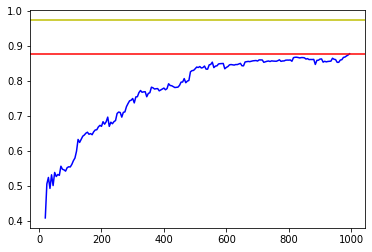

In [37]:
# p_metrics, p_budget, p_annotated
r0 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=6,
    p_init=20,
    max_n_clusters=10,
    target_accuracy=target_accuracy,)

plt.plot(r0[2], r0[0], color='b')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

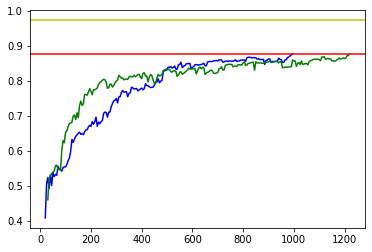

In [43]:
r1 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=10,
    p_init=20,
    max_n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r0[2], r0[0], color='b')
plt.plot(r1[2], r1[0], color='g')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

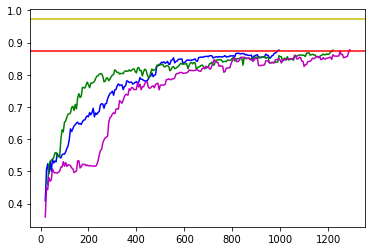

In [42]:
r2 = active_cluster(
    x_train,
    y_train,
    p_batch_size=5,
    p_epochs=20,
    p_init=20,
    max_n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r0[2], r0[0], color='b')
plt.plot(r1[2], r1[0], color='g')
plt.plot(r2[2], r2[0], color='m')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

In [ ]:
r3 = active_cluster(
    x_train,
    y_train,
    p_batch_size=7,
    p_epochs=20,
    p_init=20,
    max_n_clusters=10,
    target_accuracy=target_accuracy)

plt.plot(r0[2], r0[0], color='g')
plt.plot(r1[2], r1[0], color='b')
plt.plot(r2[2], r2[0], color='o')
plt.plot(r3[2], r3[0], color='k')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')

0.8259999752044678 400
0.8744000196456909 800


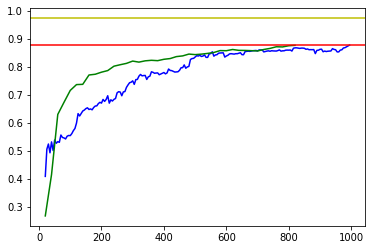

In [148]:
r0v2 = active_cluster(
    x_train,
    y_train,
    p_batch_size=20,
    p_epochs=6,
    p_init=20,
    max_n_clusters=10,
    target_accuracy=target_accuracy,
#    custom_acquisition_fn=samp_var_acquisition_fn
)

plt.plot(r0[2], r0[0], color='b')
plt.plot(r0v2[2], r0v2[0], color='g')
plt.axhline(target_accuracy, color='r')
plt.axhline(baseline_metrics, color='y')